In [12]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from numpy import linalg as LA

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [14]:
file_name = '128_relu_40_adjacentTF_3e-5'

In [15]:
emb = pd.read_csv(f'./emb/{file_name}.csv', index_col=0)

k_emb = emb[emb['type'] == 1].copy(deep=True)
gm_emb = emb[emb['type'] == 2].copy(deep=True)
# gene_emb = emb[emb['type'] == 0].copy(deep=True)

emb.drop('type' , axis='columns', inplace=True)
k_emb.drop('type', axis='columns', inplace=True)
gm_emb.drop('type', axis='columns', inplace=True)
# gene_emb.drop('type', axis='columns', inplace=True)

print(f'K562: {k_emb.shape}')
print(f'GM12878: {gm_emb.shape}')
# print(f'Gene: {gene_emb.shape}')
emb.dtypes

K562: (69, 128)
GM12878: (69, 128)


0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
123    float64
124    float64
125    float64
126    float64
127    float64
Length: 128, dtype: object

## Check for normalization

In [16]:
is_normalized = pd.DataFrame(LA.norm(emb.to_numpy(), axis=1), index=emb.index, columns=['sqr_sum'])
is_normalized['is_normalized'] = is_normalized['sqr_sum'].map(lambda x: x - 1 < 1e-5)
from collections import Counter
Counter(is_normalized['is_normalized'])## Plot embedding of TFs

Counter({True: 18573})

The result embedding is indeed normalized

## Plot Embedding of TFs

In [17]:
tf_emb = pd.concat([gm_emb, k_emb])
all_embeddings = tf_emb.to_numpy()
nodes = tf_emb.index.to_numpy()

In [18]:
trans = TSNE(n_components=2, random_state=0, n_iter=5000)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=nodes)
emb_transformed['type'] = emb_transformed.index.map(lambda name: 1 if name[-2:] == '_k' else 2)


In [19]:
emb_transformed.loc['MYC_gm']

0      -10.674283
1       -4.534194
type     2.000000
Name: MYC_gm, dtype: float64

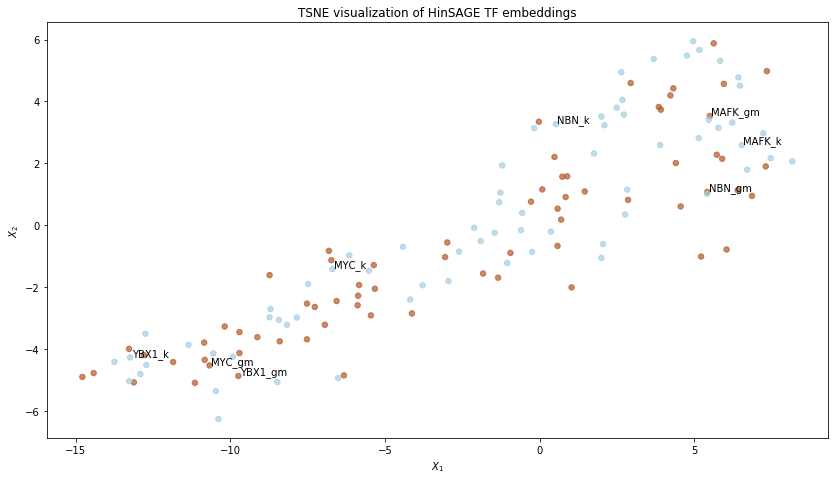

In [20]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 14))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=30
)


# mark out some nodes
target_nodes = ['MYC', 'YBX1', 'MAFK', 'NBN']
target_txts = []
for n in target_nodes:
    target_txts.append(n + '_k')
    target_txts.append(n + '_gm')
for i, txt in enumerate(nodes):
    if txt in target_txts or False:
        ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE TF embeddings")

plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
plt.show()

## Calculate embedding distance
1. Traverse all TFs, calculate L2 distance


In [10]:
tf_names = k_emb.index.map(lambda name: name[:-2]).to_list()
k_names = k_emb.index.to_list()
gm_names = gm_emb.index.to_list()

iterables = [list(gm_names), list(k_names)] 
idx = pd.MultiIndex.from_product(iterables, names=['gm', 'k'])

tf_emb_dist = pd.DataFrame(index=idx, columns=['distance'], dtype=np.float32)
tf_emb_dist['gm_emb'] = tf_emb_dist.index.map(lambda x: gm_emb.loc[x[0]])
tf_emb_dist['k_emb'] = tf_emb_dist.index.map(lambda x: k_emb.loc[x[1]])

def get_dist(x):
    return LA.norm(x[0].to_numpy() - x[1].to_numpy())

tf_emb_dist['distance'] = tf_emb_dist[['gm_emb', 'k_emb']].apply(get_dist, axis=1)

tf_emb_dist

distance  \
gm                 k                    
POLR2AphosphoS5_gm ZNF143_k  0.089934   
                   YY1_k     0.088776   
                   BCLAF1_k  0.132805   
                   NFYA_k    0.144049   
                   ETS1_k    0.066094   
...                               ...   
GABPA_gm           ZNF274_k  0.182634   
                   MAZ_k     0.158302   
                   CHD2_k    0.127039   
                   CBX5_k    0.165133   
                   NBN_k     0.116049   

                                                                        gm_emb  \
gm                 k                                                             
POLR2AphosphoS5_gm ZNF143_k  0     0.000000
1     0.000000
2     0.000000
3...   
                   YY1_k     0     0.000000
1     0.000000
2     0.000000
3...   
                   BCLAF1_k  0     0.000000
1     0.000000
2     0.000000
3...   
                   NFYA_k    0     0.000000
1     0.000000
2     0.000000
3...   
                   ETS1_k    0     0.000000
1     0.000000
2     0.000000
3...   
...                                                                        ...   
GABPA_gm           ZNF274_k  0     0.000000
1     0.000000
2     0.000000
3...   
                   MAZ_k     0     0.000000
1     0.000000
2     0.000000
3...   
                   CHD2_k    0     0.000000
1     0.000000
2     0.000000
3...   
                   CBX5_k    0     0.000000
1     0.000000
2     0.000000
3...   
                   NBN_k     0     0.000000
1     0.000000
2     0.000000
3...   

                                                                         k_emb  
gm                 k                                                            
POLR2AphosphoS5_gm ZNF143_k  0     0.000000
1     0.000000
2     0.000000
3...  
                   YY1_k     0     0.000000
1     0.000000
2     0.000000
3...  
                   BCLAF1_k  0     0.000000
1     0.000000
2     0.000000
3...  
                   NFYA_k    0     0.000000
1     0.000000
2     0.000000
3...  
                   ETS1_k    0     0.000000
1     0.000000
2     0.000000
3...  
...                                                                        ...  
GABPA_gm           ZNF274_k  0     0.000000
1     0.000000
2     0.000000
3...  
                   MAZ_k     0     0.000000
1     0.000000
2     0.000000
3...  
                   CHD2_k    0     0.000000
1     0.000000
2     0.000000
3...  
                   CBX5_k    0     0.000000
1     0.000000
2     0.000000
3...  
                   NBN_k     0     0.000000
1     0.000000
2     0.000000
3...  

[4761 rows x 3 columns]

We sort the DataFrame according to distance

In [36]:
tf_emb_dist_sorted = tf_emb_dist.sort_values(['gm', 'distance'], ascending=False)
tf_emb_dist_sorted.drop(['gm_emb', 'k_emb'], axis=1, inplace=True)
tf_emb_dist_sorted

distance
gm        k                          
ZNF274_gm SMC3_k             0.657422
          POLR3G_k           0.587022
          REST_k             0.582401
          STAT5A_k           0.528381
          RAD21_k            0.517554
...                               ...
ATF3_gm   POLR2AphosphoS2_k  0.131406
          MLLT1_k            0.129469
          USF2_k             0.107966
          POLR2AphosphoS5_k  0.101934
          IKZF1_k            0.099030

[4761 rows x 1 columns]